In [1]:
import collections
import csv
import keras
import keras.backend as K
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import time
import shap
import ROOT as root
from sklearn.preprocessing import StandardScaler

from keras import optimizers
from keras.regularizers import l2
from keras.layers import Dense, LayerNormalization, BatchNormalization, Dropout, GaussianNoise, Activation, Add
from keras import activations
from ROOT import TFile, TLorentzVector

from tools.constants import *

Welcome to JupyROOT 6.22/08


In [2]:
import numpy as np
import matplotlib.pyplot as plt

tth_filenames = ["data/mmc/MMC_output_test_wide_ttH.csv"]
ttz_filenames = ["data/mmc/MMC_output_test_wide_ttZ.csv"]
ttw_filenames = ["data/mmc/MMC_output_test_wide_ttW.csv"]
tt_filenames = ["data/mmc/MMC_output_test_wide_tt.csv"]

tth_data = []
ttz_data = []
ttw_data = []
tt_data = []

for filename in tth_filenames:
    with open(filename) as f:   
        data  = np.loadtxt(f, delimiter=",")
        tth_data += data.tolist()

for filename in ttz_filenames:
    with open(filename) as f:
        data  = np.loadtxt(f, delimiter=",")
        ttz_data += data.tolist()

for filename in ttw_filenames:
    with open(filename) as f:   
        data  = np.loadtxt(f, delimiter=",")
        ttw_data += data.tolist()

for filename in tt_filenames:
    with open(filename) as f:
        data  = np.loadtxt(f, delimiter=",")
        tt_data += data.tolist()        

print(np.count_nonzero(tth_data)/len(tth_data))
print(np.count_nonzero(ttz_data)/len(ttz_data))
print(np.count_nonzero(ttw_data)/len(ttw_data))
print(np.count_nonzero(tt_data)/len(tt_data))
tth_data = np.array(tth_data)
ttz_data = np.array(ttz_data)
ttw_data = np.array(ttw_data)
tt_data = np.array(tt_data)
print(tth_data.shape)
print(ttz_data.shape)
print(ttw_data.shape)
print(tt_data.shape)

tth_nonzero = tth_data[np.nonzero(tth_data)]
ttz_nonzero = ttz_data[np.nonzero(ttz_data)]
ttw_nonzero = ttw_data[np.nonzero(ttw_data)]
tt_nonzero = tt_data[np.nonzero(tt_data)]

print(np.mean(tth_nonzero), np.std(tth_nonzero))
#print(np.mean(ttz_nonzero), np.std(ttz_nonzero))
#print(np.mean(ttw_nonzero), np.std(ttw_nonzero))
#print(np.mean(tt_nonzero), np.std(tt_nonzero))

0.7676562288193033
0.8012991975544517
0.6947368421052632
0.8178807947019867
(7377,)
(2617,)
(1330,)
(604,)
137.5340346106304 88.49389060179782


In [9]:
import atlasplots as aplt
import root_numpy
from ROOT import TF1, TLine

aplt.set_atlas_style()

H_line = TLine(125.18,0,125.18,10000)
H_line.SetLineStyle(9)
H_line.SetLineWidth(3)
Z_line = TLine(91.19,0,91.19,10000)
Z_line.SetLineStyle(9)
Z_line.SetLineWidth(3)
W_line = TLine(80.38,0,80.38,10000)
W_line.SetLineStyle(9)
W_line.SetLineWidth(3)

gauss_fit_2 = TF1("gauss_fit_2","gaus(0)",0,300)
gauss_fit_2.SetParameters(1, 1, 1)



ttH = root.TH1F("ttH","",30,1,300)
root_numpy.fill_hist(ttH, tth_data)

weights1 = np.ones(len(ttz_data))*(len(tth_data)/len(ttz_data))

ttZ = root.TH1F("ttZ","",30,1,300)
root_numpy.fill_hist(ttZ, ttz_data, weights1)

weights2 = np.ones(len(ttw_data))*(len(tth_data)/len(ttw_data))

ttW = root.TH1F("ttW","",30,1,300)
root_numpy.fill_hist(ttW, ttw_data, weights2)

weights3 = np.ones(len(tt_data))*(len(tth_data)/len(tt_data))

tt = root.TH1F("tt","",30,1,300)
root_numpy.fill_hist(tt, tt_data, weights3)



fig, ax = aplt.subplots(1, 1)

ttH.Fit("gauss_fit_2","0")
gauss_fit_2.SetNpx(1000)
#ax.plot(gauss_fit_2, label="Fit", labelfmt="L", linecolor=root.kRed+1, linewidth=3)



ttH_fit = ttH.GetFunction("gauss_fit_2")
print(ttH_fit.GetParameter(0))
print(ttH_fit.GetParameter(1))
print(ttH_fit.GetParameter(2))
ax.plot(H_line, linecolor='black', label=None, labelfmt="L")
ax.plot(Z_line, linecolor='black', label=None, labelfmt="L")
ax.plot(W_line, linecolor='black', label=None, labelfmt="L")

ax.plot(ttH, linecolor='blue', linewidth=3, label="ttH", labelfmt="L")
ax.plot(ttZ, linecolor=807, linewidth=3, label="ttZ", labelfmt="L")
ax.plot(ttW, linecolor=root.kGreen+1, linewidth=3, label="ttW", labelfmt="L")
ax.plot(tt, linecolor=root.kViolet-2, linewidth=3, label="tt", labelfmt="L")

ax.set_xlim(0, 300)
ax.set_ylim(0, 900)
ax.set_xlabel("Mass [GeV]")
ax.set_ylabel("Events")
ax.add_margins(top=0.15)
ax.legend(loc=(0.85, 0.7, 0.95, 0.92))
fig.savefig("figures/mass_histo_full_root_mmc.pdf")

Applying ATLAS style settings
449.24153266649785
115.30697171076963
43.300656787634935
 FCN=533.213 FROM MIGRAD    STATUS=CONVERGED      78 CALLS          79 TOTAL
                     EDM=4.79542e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.49242e+02   8.88561e+00   7.27678e-02  -4.38222e-05
   2  Mean         1.15307e+02   7.73269e-01   7.20750e-03  -4.09003e-05
   3  Sigma        4.33007e+01   6.11697e-01   3.07325e-05  -9.01658e-02


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

0.8084587230581537
1.3104812129202372


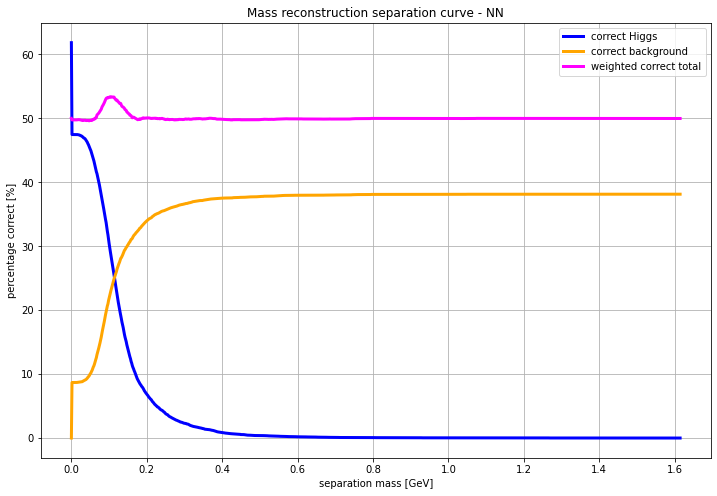

53.389961441023246


In [4]:
ttH_y_pred = tth_data
ttZ_y_pred = ttz_data
ttW_y_pred = ttw_data
tt_y_pred = tt_data

min_mass = np.min(np.concatenate((ttH_y_pred, ttZ_y_pred, ttW_y_pred, tt_y_pred)))
max_mass = np.max(np.concatenate((ttH_y_pred, ttZ_y_pred, ttW_y_pred, tt_y_pred)))

bg_weight = (len(ttZ_y_pred)+len(ttH_y_pred)+len(ttW_y_pred)+len(tt_y_pred))/2/(len(ttZ_y_pred)+len(ttW_y_pred)+len(tt_y_pred))
h_weight = (len(ttZ_y_pred)+len(ttH_y_pred)+len(ttW_y_pred)+len(tt_y_pred))/2/len(ttH_y_pred)
print(h_weight)
print(bg_weight)

n_steps = 1000
step_size = (max_mass-min_mass)/n_steps
current_divider = min_mass

correct_h = np.zeros((n_steps))
correct_bg = np.zeros((n_steps))

incorrect_h = np.zeros((n_steps))
incorrect_bg = np.zeros((n_steps))

steps = np.zeros((n_steps))

for i in range(n_steps):

    current_divider = min_mass+i*step_size
    steps[i] = current_divider

    for h_mass in ttH_y_pred:
        if h_mass < current_divider:
            incorrect_h[i] += 1
        else:
            correct_h[i] += 1

    for z_mass in ttZ_y_pred:
        if z_mass < current_divider:
            correct_bg[i] += 1
        else:
            incorrect_bg[i] += 1
    for W_mass in ttW_y_pred:
        if W_mass < current_divider:
            correct_bg[i] += 1
        else:
            incorrect_bg[i] += 1
    for _0_mass in tt_y_pred:
        if _0_mass < current_divider:
            correct_bg[i] += 1
        else:
            incorrect_bg[i] += 1

steps = steps/1000
correct_h /= (len(ttH_y_pred)+len(ttZ_y_pred)+len(ttW_y_pred)+len(tt_y_pred))/100
correct_bg /= (len(ttH_y_pred)+len(ttZ_y_pred)+len(ttW_y_pred)+len(tt_y_pred))/100
plt.figure(figsize=(12,8))
plt.plot(steps, correct_h, linewidth=3, color='blue')
plt.plot(steps, correct_bg, linewidth=3, color='orange')
plt.plot(steps, h_weight*correct_h + bg_weight*correct_bg, linewidth=3, color='magenta')
plt.title("Mass reconstruction separation curve - NN")
plt.xlabel("separation mass [GeV]")
plt.ylabel("percentage correct [%]")
plt.legend(["correct Higgs","correct background","weighted correct total"])
plt.grid()
#plt.savefig("1213_meeting/separation_curve.pdf")
plt.show()
print(np.max(h_weight*correct_h + bg_weight*correct_bg))